## Sentiment Analysis with Padl
This notebook implements and trains a Sentiment Monitor using `padl`. First, let's make sure we have all the requirements installed.

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install sentencepiece
#!pip install matplotlib
#!pip install torch

We import `padl` along all the needed libraries and define some required constants for the model. From `padl` we import the elements `transform`, `batch`, `unbatch`, `same` and `identity`:
- `transform`: Any callable class implementing `__call__` or any class inheriting `torch.nn.Module` (and implementing `forward`) can become a `Base` using the `transform` decorator. 

- `batch`: Stands for `padl.transforms.Batchify`, which determines where the dataloader is called, and the batchs are created sent to the gpu.

- `unbatch`: Stands for `padl.transforms.Unbatchify`, which unbatches the output of the neural network and indicates the beginning of the postprocess stage, carried out on the cpu.

- `same`: Operator for calling methods or attributes of the object passed through it. For example: `same.count(5)([5, 7, 8, 5, 5) # outputs 3`

- `identity`: Stands for `padl.transforms.Identity()`, which is the Identity transform.

For our model we will also use the some global variables: `VOCAB_SIZE`, `TRAIN_TEST_SPLIT`, `EMB_DIM`, `RNN_HIDDEN_SIZE`, `DECODER_HIDDEN`, `PADDING_PERCENTILE`.

In [2]:
import os 
import uuid
import numpy
import pandas
import sentencepiece
import torch
import matplotlib.pyplot as plt

import padl
from padl import transform, batch, unbatch, same, identity

VOCAB_SIZE = 5000 # Size of the vocabulary used by our tokenizer  
TRAIN_TEST_SPLIT = 10000 # Number of components of each embedding vector
EMB_DIM = 64 # Number of components of each embedding vector
RNN_HIDDEN_SIZE = 1024 # Hidden size of our recurrent layer
DECODER_HIDDEN = 64 # Number of hidden dimensions in the dense layers after the rnn
PADDING_PERCENTILE = 99 # Percentile of datapoints at which we want to truncate our padding

### The data
The dataset used in this notebook is `Sentiment140`, which contains 1.6 million of tweets classified as negative (0) or positive (4). The dataset can be download from kaggle:

https://www.kaggle.com/kazanova/sentiment140

We rename the file to `data.csv`, we shuffle it and subsample the 10% of it to train faster along that data subset.

In [3]:
data = pandas.read_csv(
    'data.csv',
    header=None,
    sep=',',
).sample(frac=0.1, random_state=0).reset_index(drop=True)

Let's check out the data.

In [6]:
data.head(10)

,0,1,2,3,4,5
0,0,2204444171,Wed Jun 17 02:14:00 PDT 2009,NO_QUERY,einmensch,wants to compete! i want hard competition! i w...
1,0,2017152437,Wed Jun 03 07:56:34 PDT 2009,NO_QUERY,keithmorrison,It seems we are stuck on the ground in Amarill...
2,0,1967043408,Fri May 29 18:52:13 PDT 2009,NO_QUERY,PunkieDory,where the f are my pinking shears? rarararrrar...
3,0,2208721054,Wed Jun 17 09:32:48 PDT 2009,NO_QUERY,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
4,4,2018731586,Wed Jun 03 10:25:27 PDT 2009,NO_QUERY,BlueSmartiies,@ reply me pls
5,0,2295875426,Tue Jun 23 08:29:12 PDT 2009,NO_QUERY,abtony,@bharathy_99: Jazz in India is just Honda stra...
6,4,1965198843,Fri May 29 15:30:08 PDT 2009,NO_QUERY,alitheoctopus,"aaaaaaaaaaah, met a boy. he seems nice. im hap..."
7,4,2051339641,Fri Jun 05 21:42:52 PDT 2009,NO_QUERY,RooookieP,@jonasbrothers http://twitpic.com/6q1om - Spor...
8,4,1969949901,Sat May 30 01:51:05 PDT 2009,NO_QUERY,namakemono49,"@saragarth Not bad, bit grumpy cause of exams ..."
9,0,1694969873,Mon May 04 04:46:43 PDT 2009,NO_QUERY,Exercise999,@luke_redroot can't watch it what is it?


We only need the first (label) and the last (text) columns. We keep, rename them and split in train and valid sets.

In [7]:
data = data.drop(labels=[1, 2, 3, 4], axis=1).rename(columns={0: 'label', 5: 'text'})
data['label'] = data['label'].apply(lambda x: int(x/4))
data_list = list(zip(data['text'], data['label']))
train_data = data_list[:-TRAIN_TEST_SPLIT]
valid_data = data_list[-TRAIN_TEST_SPLIT:]

We dump a text file with one sentence on each line that will be used for training our tokenizer.

In [8]:
with open('corpus.txt', 'w') as f:
    f.writelines(data['text'][:-TRAIN_TEST_SPLIT].apply(lambda x: x + '\n').tolist())

### Creating the Transforms
It is time to proceed to define and instantiate the `Base` we are going to use in our model. With `padl` this is very easy! We write functions and classes implementing a `__call__` method or a `forward` if they  inherit `torch.nn.Module`, and we add the `@transform` decorator. Then, they will be ready to use the `padl` features like saving, composing, applying... As simple as that!

We create the following ones:
- `Bpe`: Consists of a tokenizer based on the byte pair encoding algorithm and uses the `sentencepiece` package.
- `Pad_Seq`: Pads our sentences so they have the same sequence length and can be processed into batches. In our case, we choose a padding length at the 99th percentile of lengths of the samples.
- `Embedding`: Our tokens embedder.
- `MyNN`: Class containing our architecture.
- `classify`: postprocess the output of the neural network.
- `to_tensor`: converts the input to a `torch.Tensor`.
- `loss_function`: loss function used on the training, which is the CrossEntropyLoss.
- `norm`: computes probability values using a softmax function. This is used in the infer mode to get an idea of the probabilities of positiveness and negativeness.

In [9]:
@transform
class Bpe:
    def __init__(self):
        self._model = None
        self.vocab_size = None
        self.dic = None
        self.model_prefix = str(uuid.uuid4())
        
    def __call__(self, x):
        return self._model.encode_as_ids(x)
    
    def fit(self, corpus_file):
        sentencepiece.SentencePieceTrainer.Train(
            f'--input={corpus_file} '
            f'--model_prefix={self.model_prefix} '
            f'--vocab_size={VOCAB_SIZE} '
            f'--character_coverage={1.0} '
            '--model_type=bpe '
        )
        self._model = sentencepiece.SentencePieceProcessor()
        self._model.Load(f'{self.model_prefix}.model')
        self.vocab_size = self._model.vocab_size()
        self.dic = {i:self._model.decode([i]) for i in range(self.vocab_size)}
        with open(f'{self.model_prefix}.model', 'rb') as f:
            self._content = f.read()
        os.remove(f'{self.model_prefix}.model')
        os.remove(f'{self.model_prefix}.vocab')
    
    def post_load(self, path, i):
        self._model = sentencepiece.SentencePieceProcessor()
        self._model.Load(str(path / f'{i}.model'))
    
    def pre_save(self, path, i):
        with open(path / f'{i}.model', 'wb') as f:
            f.write(self._content)

    
@transform
class Pad_Seq:
    def __init__(self, seq_len):
        self.seq_len = seq_len
    
    def __call__(self, seq):
        if len(seq) < self.seq_len:
            return seq + [2 for i in range(len(seq), self.seq_len)], [len(seq)]
        return seq[:self.seq_len], [self.seq_len] 

    
@transform
class MyNN(torch.nn.Module):
    def __init__(self, hidden_size, decoder_hidden, emb_dim):
        super().__init__()
        self.hidden_size = hidden_size
        self.decoder_hidden = decoder_hidden
        self.lstm = torch.nn.LSTM(
            input_size=emb_dim,
            hidden_size=self.hidden_size, 
            batch_first=True
        )
        self.lin1 = torch.nn.Linear(self.hidden_size, self.decoder_hidden)
        self.act = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(self.decoder_hidden, 2)
    
    def forward(self, x, lengths=None):
        out, state = self.lstm(x)
        if self.pd_mode != 'infer':
            output = [sentence[length.item() - 1 , :] for sentence, length in zip(out, lengths)]
            output = torch.stack(output)
        if self.pd_mode == 'infer':
            output = state[0].squeeze(0)
        dec = self.lin1(output)
        dec = self.act(dec)
        return self.lin2(dec)
    

@transform
def classify(x):
    negative_score = x[0].item()
    positive_score = x[1].item()
    if positive_score > 0.6:
        category = 'Positive'
    elif 0.4 < positive_score <= 0.6:
        category = 'Neutral'
    elif 0.4 <= positive_score:
        category = 'Negative'
    return {'Negativeness': round(negative_score, 2),
            'Positiveness': round(positive_score, 2), 'Sentiment': category}

bpe = Bpe()
bpe.fit('corpus.txt')

random_sample = [train_data[i][0] for i in numpy.random.permutation(len(train_data))[:10000]]
len_list = [len(bpe(sent)) for sent in random_sample]
seq_len = int(numpy.quantile(len_list, 0.01 * PADDING_PERCENTILE))

print(f'sequence-length chosen on 99th percentile: {seq_len}')

pad = Pad_Seq(seq_len)
to_tensor = transform(lambda x: torch.LongTensor(x))
emb = transform(torch.nn.Embedding)(VOCAB_SIZE, EMB_DIM)
nn = MyNN(
    hidden_size=RNN_HIDDEN_SIZE,
    decoder_hidden=DECODER_HIDDEN,
    emb_dim=EMB_DIM,
)
loss_function = transform(torch.nn.CrossEntropyLoss)()
norm = transform(torch.nn.Softmax)(dim=-1)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=corpus.txt --model_prefix=110d0265-edda-4776-b57d-c319336c1e8e --vocab_size=5000 --character_coverage=1.0 --model_type=bpe 
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: 110d0265-edda-4776-b57d-c319336c1e8e
  model_type: BPE
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 

sequence-length chosen on 99th percentile: 52


Let's represent graphically the distribution of the sequence length of a subsample of our data. As we see, with out padding to a sequence length of 52 we keep the 99% of our sentences.

(array([3.600e+02, 1.178e+03, 1.675e+03, 1.546e+03, 1.333e+03, 1.152e+03,
        1.037e+03, 8.310e+02, 5.540e+02, 2.140e+02, 7.800e+01, 2.200e+01,
        8.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   5.95,  10.9 ,  15.85,  20.8 ,  25.75,  30.7 ,  35.65,
         40.6 ,  45.55,  50.5 ,  55.45,  60.4 ,  65.35,  70.3 ,  75.25,
         80.2 ,  85.15,  90.1 ,  95.05, 100.  ]),
 <BarContainer object of 20 artists>)

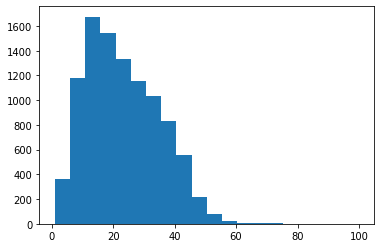

In [10]:
plt.hist(len_list, bins=20)

### Building and training the model.

We build now our training and infer pipelines. Let's make a quick reminder of the `padl` operators:
- `>>`: Compose operator: $(f_1 >> f_2)(x) \rightarrow f_2(f_1(x))$
- `+`: Rollout operator: $(f_1 + f_2) (x) \rightarrow (f_1(x), f_2(x))$
- `/`: Parallel operator: $(f_1 / f_2)((x_1,x_2)) \rightarrow (f_1(x_1), f_2(x_2))$
- `~`: Map operator: $(~f)([x_1, ..., x_n]) \rightarrow ([f(x_1), ..., f(x_n)]$
- `-`: Name operator: Names a transform so that its output can be accesed by given name or the transform itself can be accessed by its name from the pipeline:  
    - $((f_1 - \text{'zulu'})+f_2)(x) \rightarrow \text{Namedtuple}(\text{'zulu'}:f_1(x), \text{'out_1'}:f_2(x))$
    - $((f_1 - \text{'zulu'})+f_2)[\text{'zulu'}] = f_1$

In [11]:
data_model = ( 
    same[0] 
    >> bpe 
    >> pad 
    >> ~ to_tensor  
    >> batch
    >> emb / identity  
    >> nn
)
targets = same[1] >> batch
model = data_model + targets >> loss_function

infer_model = (
    bpe
    >> to_tensor
    >> batch
    >> emb
    >> nn
    >> norm
    >> unbatch
    >> classify
)

Below, the model is trained for 20 epochs using an Adam optimization algorithm, validating each 100 steps and saving using the `pd_save` method. 

`Padl` provides a built-in feature for saving a `Base`, which is the `pd_save` method. A `Base` inheriting `torch.nn.Module` has a default saving using the `torch` saving functionality. If other `Base` need to save anything, like `Bpe` in this example, we need to define a way to save and load, implemented respectively in the `pre_save` and `post_load` methods. If we want to overwrite a saved `padl` model which exists at the same path, we need to set the argument `force_overwrite` to `True`. 

In [12]:
model.pd_to('cuda')
max_accuracy = 0.
optimizer = torch.optim.Adam(model.pd_parameters(), lr=1e-4)
it = 0
num_epochs = 20
train_batch_size = 4000
valid_batch_size = 4000

if os.path.exists('train_file.csv'):
    os.remove('train_file.csv')

if os.path.exists('valid_file.csv'):
    os.remove('valid_file.csv')

for epoch in range(num_epochs):
    print('Start epoch %d'%epoch)
    for loss in model.train_apply(train_data, batch_size=train_batch_size):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if it % 10 == 0:
            print(f'TRAIN iteration {it}; loss: {loss.item()}')
            with open('train_file.csv', 'a') as f:
                f.write(f'{loss.item()}\n')
        if it % 100 == 0:
            counter = 0.
            accuracy = 0.
            for res, targets in model[:-1].eval_apply(valid_data, batch_size=valid_batch_size):
                top_prob, preds = res.topk(1, dim=1)
                correct = (preds.view(-1) == targets)
                accuracy += torch.mean(correct.type(torch.FloatTensor))
                counter += 1
            accuracy = accuracy/counter
            print(f'VALID_accuracy: {accuracy}')
            with open('valid_file.csv', 'a') as f:
                f.write(f'{accuracy}\n')
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                print('Saving...')
                infer_model.pd_save('sent_analysis.padl', force_overwrite=True)
        it += 1 

Start epoch 0
TRAIN iteration 0; loss: 0.6947038769721985
VALID_accuracy: 0.4934999942779541
Saving...
saving torch module to sent_analysis.padl/sent_analysis_4.pt
saving torch module to sent_analysis.padl/sent_analysis_5.pt
saving torch module to sent_analysis.padl/sent_analysis_6.pt
TRAIN iteration 10; loss: 0.6906222105026245
TRAIN iteration 20; loss: 0.6859002709388733
TRAIN iteration 30; loss: 0.6752104163169861
Start epoch 1
TRAIN iteration 40; loss: 0.6641473174095154
TRAIN iteration 50; loss: 0.6562404036521912
TRAIN iteration 60; loss: 0.652820885181427
TRAIN iteration 70; loss: 0.6427056789398193
Start epoch 2
TRAIN iteration 80; loss: 0.6457321643829346
TRAIN iteration 90; loss: 0.6501889824867249
TRAIN iteration 100; loss: 0.6404860615730286
VALID_accuracy: 0.6357499957084656
Saving...
saving torch module to sent_analysis.padl/sent_analysis_4.pt
saving torch module to sent_analysis.padl/sent_analysis_5.pt
saving torch module to sent_analysis.padl/sent_analysis_6.pt
TRAIN it

Now we can load and use our trained models with  the `load` function.

In [22]:
loaded_model = padl.load('sent_analysis.padl')

loading torch module from sent_analysis.padl/sent_analysis_4.pt
loading torch module from sent_analysis.padl/sent_analysis_5.pt
loading torch module from sent_analysis.padl/sent_analysis_6.pt


In [21]:
loaded_model.infer_apply('Padl is a powerful and super cool tool!')

{'Negativeness': 0.24, 'Positiveness': 0.76, 'Sentiment': 'Positive'}

And that's it! This is how easy is to build, train, save and load models with `padl`.